# GAN para generación de caras

Usamos el dataset CelebA para entrenar una red neuronal generativa antagónica para generar caras.

In [9]:
# Importa las librerias necesarias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam

In [10]:
# Descomprime el dataset de imagenes (En caso de hacerlo en colab)
# !unzip /content/drive/MyDrive/datasets/img_celeba_89x109.zip

In [11]:
# Verificamos que las imagenes se han extraido correctamente
data_dir = "D:\CEIABD\img_align_celeba_89x109"

if os.path.exists(data_dir):
    files = os.listdir(data_dir) # Lista con los nombres de los ficheros
    print(f"Total de imágenes: {len(files)}")
    print(f"Algunos ejemplos de imágenes: {files[:10]}")
else:
    print(f"La carpeta {data_dir} no existe.")

Total de imágenes: 202599
Algunos ejemplos de imágenes: ['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg', '000005.jpg', '000006.jpg', '000007.jpg', '000008.jpg', '000009.jpg', '000010.jpg']


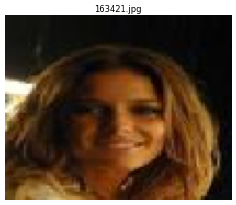

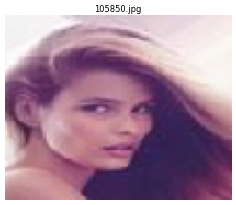

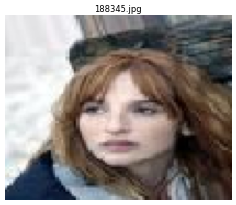

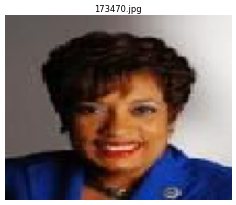

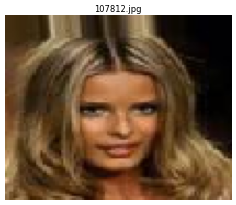

In [12]:
# Carga y muestra algunas imagenes del dataset
sample_files = random.sample(files, 5)

for file_name in sample_files:
    image_path = os.path.join(data_dir, file_name)
    image = load_img(image_path, target_size=(89, 109))
    plt.figure(dpi=50)
    plt.title(file_name)
    plt.imshow(image)
    plt.axis("off")
    plt.show()

In [13]:
# Carga y procesado del dataset CelebA

# Parametros del dataset y del modelo
IMG_SIZE = (89, 109)
BATCH_SIZE = 32 # Probar mas adelante con un batch superior, valores como 64, 128, 512...
NUMBER_OF_FILES = 500

# Procesa las imagenes del dataset, lo ideal suele ser tener un rango de -1 a 1
images = []
for file_name in files[:NUMBER_OF_FILES]: # Subir a 2000, 10000, 20000... segun la disponibilidad de GPU/TPU
    image_path = os.path.join(data_dir, file_name)
    image = load_img(image_path, target_size=IMG_SIZE)
    image = img_to_array(image) / 127.5 - 1.0 # Normaliza entre -1 y 1, 127.5 * 2 = 255.0
    images.append(image)

# Convierte las imagenes a un array de numpy y prepara el dataset de TensorFlow
dataset = np.array(images)
dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(NUMBER_OF_FILES).batch(BATCH_SIZE)

print(f"Dataset procesado: {NUMBER_OF_FILES} imágenes cargadas y preparadas.")

Dataset procesado: 500 imágenes cargadas y preparadas.


In [14]:
# Verifica la estructura del dataset
for batch in dataset.take(1): # Toma un lote
    print("Dimensiones del lote:", batch.shape)
    print(f"Rango: ({batch.numpy().min()} a {batch.numpy().max()})")

Dimensiones del lote: (32, 89, 109, 3)
Rango: (-1.0 a 1.0)


Empezamos a crear la **GAN**.

In [21]:
# Definimos el generador 
LATENT_DIM = 100

generator = keras.Sequential([
    # Input layer
    layers.Input(shape=(LATENT_DIM,)), # Una sola dimension, por eso la coma

    # Capa inicial
    layers.Dense(6 * 7 * 512),
    # Para que los valores se mantengan, haremos normalizaciones de batch por cada capa
    layers.BatchNormalization(),
    layers.LeakyReLU(),
    # Redimension a las dimensiones iniciales
    layers.Reshape((6, 7, 512)),

    # Primera capa de convolucion
    layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Segunda capa de convolución
    layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Tercera capa de convolución
    layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Cuarta capa de convolución
    layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding="same", use_bias=False),
    layers.BatchNormalization(),
    layers.LeakyReLU(),

    # Capa final de ajuste a 89x109x3
    layers.Conv2D(3, (8, 4), activation="tanh") # tanh -> Va desde -1 a 1, el rango que tenemos nosotros, probar a quitar use_bias = False
])

generator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 21504)          │     2,171,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 21504)          │        86,016 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 21504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 6, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 12, 14, 256)    │     3,276,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 12, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 12, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 24, 28, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 24, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 24, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 48, 56, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 48, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 48, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_15             │ (None, 96, 112, 32)    │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 96, 112, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 96, 112, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 89, 109, 3)     │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,614,915 (25.23 MB)

 Trainable params: 6,570,947 (25.07 MB)

 Non-trainable params: 43,968 (171.75 KB)

In [22]:
# Dimensiones de cada capa
noise = tf.random.normal([1, LATENT_DIM])
x = noise

for layer in generator.layers:
    x = layer(x)
    print(f"{layer.name}: {x.shape}")

dense_4: (1, 21504)
batch_normalization_16: (1, 21504)
leaky_re_lu_16: (1, 21504)
reshape_4: (1, 6, 7, 512)
conv2d_transpose_12: (1, 12, 14, 256)
batch_normalization_17: (1, 12, 14, 256)
leaky_re_lu_17: (1, 12, 14, 256)
conv2d_transpose_13: (1, 24, 28, 128)
batch_normalization_18: (1, 24, 28, 128)
leaky_re_lu_18: (1, 24, 28, 128)
conv2d_transpose_14: (1, 48, 56, 64)
batch_normalization_19: (1, 48, 56, 64)
leaky_re_lu_19: (1, 48, 56, 64)
conv2d_transpose_15: (1, 96, 112, 32)
batch_normalization_20: (1, 96, 112, 32)
leaky_re_lu_20: (1, 96, 112, 32)
conv2d_3: (1, 89, 109, 3)


In [ ]:
generator_image = generator()

In [ ]:
# Definimos el discriminador
discriminator = keras.Sequential([

])